In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

#Vanilla autoencoder

In [71]:
data = np.loadtxt(open("/content/sample_data/mnist_train_small.csv",'rb'),delimiter = ',')
print(data.shape)

labels = data[:,0]
data = data[:,1:]

dataNorm = data/np.max(data)
print(dataNorm.shape)

#convert to tensor
dataT = torch.tensor(dataNorm).float()

(20000, 785)
(20000, 784)


In [9]:
def autoencoder_initialize():
  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(784,250)
      self.enc = nn.Linear(250,50)
      self.lat = nn.Linear(50,250)
      self.dec = nn.Linear(250,784)

    def forward(self,x):
      x = F.relu(self.input(x))
      x = F.relu(self.enc(x))
      x = F.relu(self.lat(x))
      x = torch.sigmoid(self.dec(x)) #input data has been normalized to lie between 0, 1; sigmoid ensure the output is the same

      return x

  ae = aenet()
  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(ae.parameters(),lr = 0.001)

  return ae,lossfun,optimizer


In [10]:
autoencoder_initialize()

(aenet(
   (input): Linear(in_features=784, out_features=250, bias=True)
   (enc): Linear(in_features=250, out_features=50, bias=True)
   (lat): Linear(in_features=50, out_features=250, bias=True)
   (dec): Linear(in_features=250, out_features=784, bias=True)
 ),
 MSELoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [14]:
#model test
ae,lossfun,optimizer = autoencoder_initialize()
y = ae(dataT[0:5,:])
loss = lossfun(y,dataT[0:5,:])
print(y.shape)
print(loss)
print(dataT[0:5,:].shape)

torch.Size([5, 784])
tensor(0.2274, grad_fn=<MseLossBackward0>)
torch.Size([5, 784])


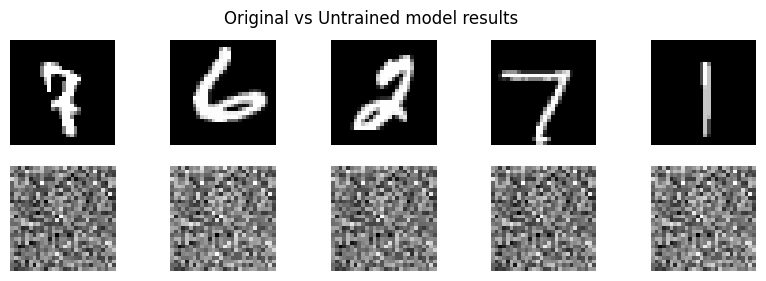

In [24]:
fig,axs = plt.subplots(2,5,figsize = (10,3))
plt.suptitle("Original vs Untrained model results")
x= dataT[0:5,:]

for i in range(5):
  axs[0,i].imshow(x[i,:].view(28,28).detach(),cmap ="gray")
  axs[1,i].imshow(y[i,:].view(28,28).detach(),cmap ="gray")

  axs[0,i].axis('off')
  axs[1,i].axis('off')


In [26]:
numepochs = 10000

#training
def autoencoder_training(model,lossfun,optimizer,numepochs,dataT):

  #initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  #loop over epochs
  for epochi in range(numepochs):
    randomidx = np.random.choice(dataT.shape[0],size = 32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = model(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #average losses across the batches
    losses[epochi] = loss.item()

  return losses,model

Text(0, 0.5, 'loss')

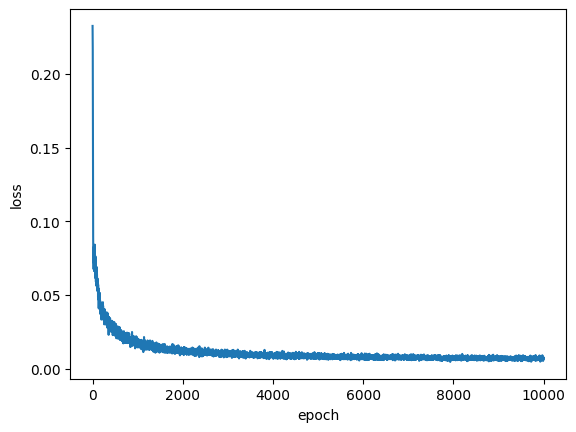

In [28]:
numepochs = 10000
ae,lossfun,optimizer = autoencoder_initialize()
losses,ae = autoencoder_training(ae,lossfun,optimizer,numepochs,dataT)

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")

In [30]:
yhat = ae(dataT)

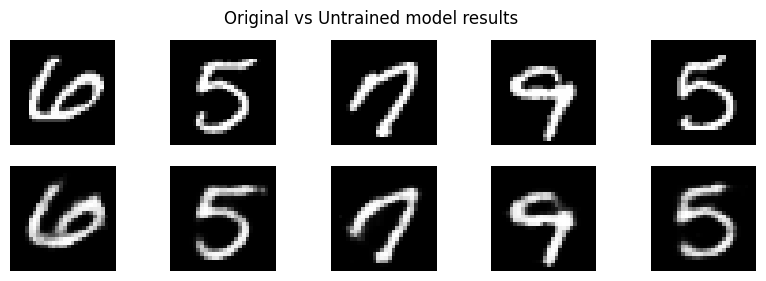

In [32]:
fig,axs = plt.subplots(2,5,figsize = (10,3))
plt.suptitle("Original vs Untrained model results")
x= dataT[0:5,:]

for i in range(5):
  axs[0,i].imshow(x[i,:].view(28,28).detach(),cmap ="gray")
  axs[1,i].imshow(yhat[i,:].view(28,28).detach(),cmap ="gray")

  axs[0,i].axis('off')
  axs[1,i].axis('off')


#De-noising

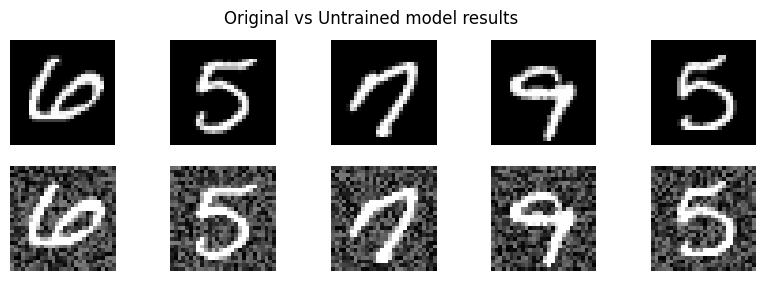

In [42]:
x = dataT[0:10,:]
xnoise = x + torch.rand_like(x)/2
xnoise[xnoise>1] = 1 #clip values>1

fig,axs = plt.subplots(2,5,figsize = (10,3))
plt.suptitle("Original vs Untrained model results")
x= dataT[0:5,:]

for i in range(5):
  axs[0,i].imshow(x[i,:].view(28,28).detach(),cmap ="gray")
  axs[1,i].imshow(xnoise[i,:].view(28,28).detach(),cmap ="gray")

  axs[0,i].axis('off')
  axs[1,i].axis('off')

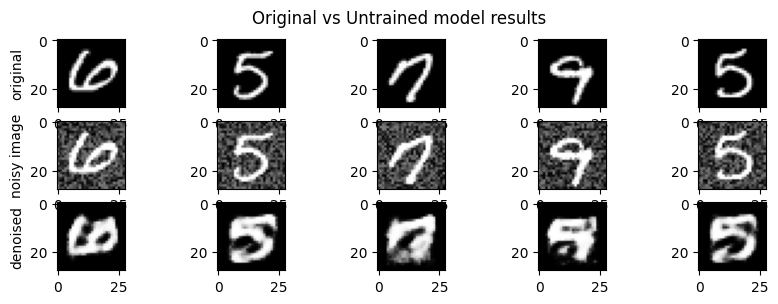

In [43]:
y = ae(xnoise)

fig,axs = plt.subplots(3,5,figsize = (10,3))
plt.suptitle("Original vs Untrained model results")
x= dataT[0:5,:]

for i in range(5):
  axs[0,i].imshow(x[i,:].view(28,28).detach(),cmap ="gray")
  axs[1,i].imshow(xnoise[i,:].view(28,28).detach(),cmap ="gray")
  axs[2,i].imshow(y[i,:].view(28,28).detach(),cmap ="gray")

  axs[0,0].set_ylabel("original")
  axs[1,0].set_ylabel("noisy image")
  axs[2,0].set_ylabel("denoised")

  #axs[0,i].axis('off')
  #axs[1,i].axis('off')
  #axs[2,i].axis('off')

#Occlusion

In [78]:
x = dataT[1,:]
y = x.view(28,28).clone() # Use .clone() for torch tensors
y[13:15,:]= 1
y = y.flatten()

Text(0.5, 1.0, 'occluded')

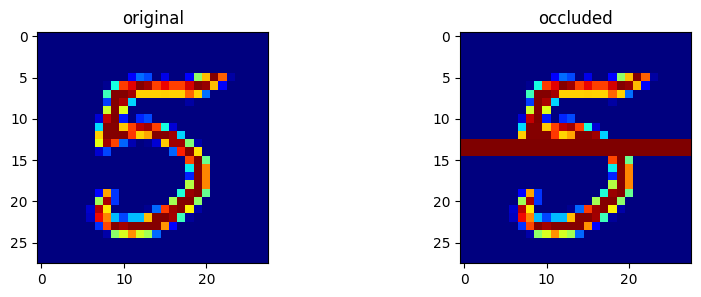

In [87]:
fig,ax = plt.subplots(1,2,figsize = (10,3))
ax[0].imshow(x.view(28,28).detach(),cmap = "jet")
ax[0].set_title("original")

ax[1].imshow(y.view(28,28).detach(),cmap = "jet")
ax[1].set_title("occluded")

Text(0.5, 1.0, 'model output (de-occluded)')

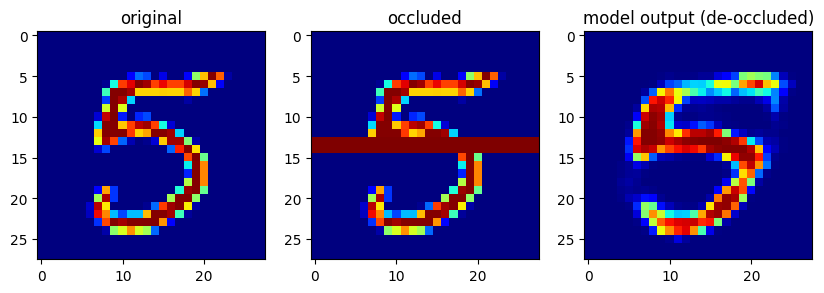

In [88]:
z = ae(y) #model trained on original image
fig,ax = plt.subplots(1,3,figsize = (10,3))

ax[0].imshow(x.view(28,28).detach(),cmap = "jet")
ax[0].set_title("original")

ax[1].imshow(y.view(28,28).detach(),cmap = "jet")
ax[1].set_title("occluded")

ax[2].imshow(z.view(28,28).detach(),cmap = "jet")
ax[2].set_title("model output (de-occluded)")

#Summary
- Butterfly architecture
- Layers : input K (1) , encoder N (multiple), bottleneck/latent M (1), decoder N(multiple), output K (1)
- K > M
- Output of autoencoder must look similar to the input
- Loss function : mean squared error; entropy etc.
- Applications : dimension reduction , data cleaning (denoising,occlusion,despeckling etc.), feature extraction, anomaly/fraud detection, pre-training deep  or complex models